เลขนักศึกษา 6609036014 กนิษฐา พูลสวัสดิ์กิติกูล
มหาวิทยาลัยธรรมศาสตร์
CS652 โดย Aj.Dr.Satanat Kitsiranuwat
TermProject : Churn Prediction Model using the proposed model by David Hason Rudd
Dataset:https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset

IMPORT LIBRARIES

In [83]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, matthews_corrcoef, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# DATAPREPROCESS

In [84]:
df = pd.read_csv(r'D:\Users\Kanittha\Desktop\CSTU2-2566\cs652 AppliedMachineLearning\TermProject\Telco_customer_churn.csv')
columns_to_drop = ['CustomerID', 'Count', 'Country', 'State','Churn Reason','City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'Churn Label', 'Churn Score', 'Churn Score', 'CLTV','Phone Service']
df.drop(columns=columns_to_drop, inplace=True)
#df.head()

In [85]:
columns_to_encoded=['Gender','Senior Citizen','Partner','Dependents', 'Multiple Lines','Internet Service','Online Security','Online Backup','Device Protection','Tech Support','Streaming TV','Streaming Movies','Contract','Paperless Billing','Payment Method']
label_encoders ={}
for column in columns_to_encoded:
    if column == 'Gender':
        df[column+'_encoded'] = df[column].map({'Female':0, 'Male':1})
    else:
        label_encoders[column] = LabelEncoder()
        df[column] = df[column].fillna('Unknown')
        df[column+'_encoded'] = label_encoders[column].fit_transform(df[column])
print("Column Encoding Mappings:")
for column, encoder in label_encoders.items():
    print(f"{column} Encoding Mapping:")
    for category, encoded_value in zip(encoder.classes_, encoder.transform(encoder.classes_)):
        print(f"{category}: {encoded_value}")
print(df)
missing_values = df.isna().sum()
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')

Column Encoding Mappings:
Senior Citizen Encoding Mapping:
No: 0
Yes: 1
Partner Encoding Mapping:
No: 0
Yes: 1
Dependents Encoding Mapping:
No: 0
Yes: 1
Multiple Lines Encoding Mapping:
No: 0
No phone service: 1
Yes: 2
Internet Service Encoding Mapping:
DSL: 0
Fiber optic: 1
No: 2
Online Security Encoding Mapping:
No: 0
No internet service: 1
Yes: 2
Online Backup Encoding Mapping:
No: 0
No internet service: 1
Yes: 2
Device Protection Encoding Mapping:
No: 0
No internet service: 1
Yes: 2
Tech Support Encoding Mapping:
No: 0
No internet service: 1
Yes: 2
Streaming TV Encoding Mapping:
No: 0
No internet service: 1
Yes: 2
Streaming Movies Encoding Mapping:
No: 0
No internet service: 1
Yes: 2
Contract Encoding Mapping:
Month-to-month: 0
One year: 1
Two year: 2
Paperless Billing Encoding Mapping:
No: 0
Yes: 1
Payment Method Encoding Mapping:
Bank transfer (automatic): 0
Credit card (automatic): 1
Electronic check: 2
Mailed check: 3


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [86]:
print(columns_to_encoded)

['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method']


In [87]:
mean_total_charges = df['Total Charges'].mean()
df['Total Charges'] = df['Total Charges'].fillna(mean_total_charges)

In [88]:
print(df['Total Charges'].isna().sum())

0


In [89]:
scaler = StandardScaler()
scaler.fit(df[['Tenure Months','Monthly Charges','Total Charges']])
df[['Tenure Months','Monthly Charges','Total Charges']] = scaler.transform(df[['Tenure Months','Monthly Charges','Total Charges']])
print(df.describe())

       Tenure Months  Monthly Charges  Total Charges  Churn Value  \
count   7.043000e+03     7.043000e+03   7.043000e+03  7043.000000   
mean   -1.614182e-17    -5.649637e-17   8.070910e-17     0.265370   
std     1.000071e+00     1.000071e+00   1.000071e+00     0.441561   
min    -1.318165e+00    -1.545860e+00  -9.998503e-01     0.000000   
25%    -9.516817e-01    -9.725399e-01  -8.305558e-01     0.000000   
50%    -1.372744e-01     1.857327e-01  -3.897629e-01     0.000000   
75%     9.214551e-01     8.338335e-01   6.637555e-01     1.000000   
max     1.613701e+00     1.794352e+00   2.826469e+00     1.000000   

       Gender_encoded  Senior Citizen_encoded  Partner_encoded  \
count     7043.000000             7043.000000      7043.000000   
mean         0.504756                0.162147         0.483033   
std          0.500013                0.368612         0.499748   
min          0.000000                0.000000         0.000000   
25%          0.000000                0.000000   

# EDA

In [90]:
df.head()
features_data_type = df.dtypes
print('Feature datatype is:')
print(features_data_type)

Feature datatype is:
Gender                        object
Senior Citizen                object
Partner                       object
Dependents                    object
Tenure Months                float64
Multiple Lines                object
Internet Service              object
Online Security               object
Online Backup                 object
Device Protection             object
Tech Support                  object
Streaming TV                  object
Streaming Movies              object
Contract                      object
Paperless Billing             object
Payment Method                object
Monthly Charges              float64
Total Charges                float64
Churn Value                    int64
Gender_encoded                 int64
Senior Citizen_encoded         int32
Partner_encoded                int32
Dependents_encoded             int32
Multiple Lines_encoded         int32
Internet Service_encoded       int32
Online Security_encoded        int32
Online Backup_enc

In [91]:
features_name = df.columns.tolist()
numerical_features = ['Tenure Months','Monthly Charges','Total Charges']
categorical_features = ['Gender', 'Senior Citizen', 'Partner', 'Dependents','Multiple Lines', 'Internet Service', 'Online Security',
                        'Online Backup', 'Device Protection', 'Tech Support','Streaming TV', 'Streaming Movies', 'Contract',
                        'Paperless Billing', 'Payment Method', 'Churn Reason','Churn Value']
numerical_df = df[numerical_features]
print(numerical_df.describe())

       Tenure Months  Monthly Charges  Total Charges
count   7.043000e+03     7.043000e+03   7.043000e+03
mean   -1.614182e-17    -5.649637e-17   8.070910e-17
std     1.000071e+00     1.000071e+00   1.000071e+00
min    -1.318165e+00    -1.545860e+00  -9.998503e-01
25%    -9.516817e-01    -9.725399e-01  -8.305558e-01
50%    -1.372744e-01     1.857327e-01  -3.897629e-01
75%     9.214551e-01     8.338335e-01   6.637555e-01
max     1.613701e+00     1.794352e+00   2.826469e+00


In [92]:
scaler = StandardScaler()
columns_to_scale = ['Tenure Months', 'Monthly Charges', 'Total Charges']
scaler.fit(df[columns_to_scale])
df[columns_to_scale] = scaler.transform(df[columns_to_scale])
print(df.describe())

       Tenure Months  Monthly Charges  Total Charges  Churn Value  \
count   7.043000e+03     7.043000e+03   7.043000e+03  7043.000000   
mean   -3.228364e-17    -1.614182e-17   1.614182e-17     0.265370   
std     1.000071e+00     1.000071e+00   1.000071e+00     0.441561   
min    -1.318165e+00    -1.545860e+00  -9.998503e-01     0.000000   
25%    -9.516817e-01    -9.725399e-01  -8.305558e-01     0.000000   
50%    -1.372744e-01     1.857327e-01  -3.897629e-01     0.000000   
75%     9.214551e-01     8.338335e-01   6.637555e-01     1.000000   
max     1.613701e+00     1.794352e+00   2.826469e+00     1.000000   

       Gender_encoded  Senior Citizen_encoded  Partner_encoded  \
count     7043.000000             7043.000000      7043.000000   
mean         0.504756                0.162147         0.483033   
std          0.500013                0.368612         0.499748   
min          0.000000                0.000000         0.000000   
25%          0.000000                0.000000   

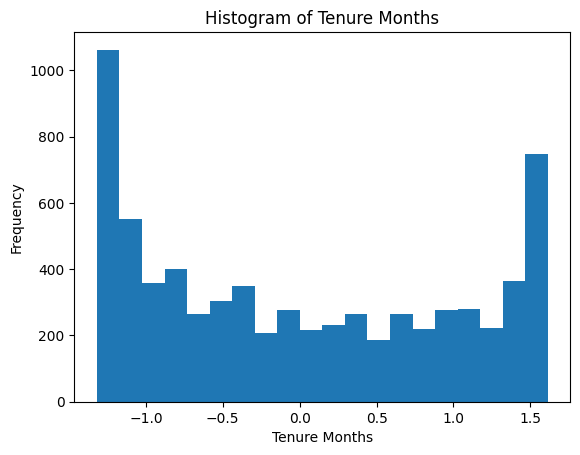

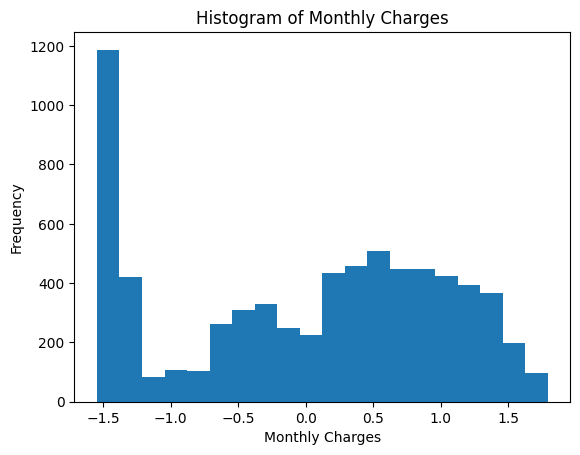

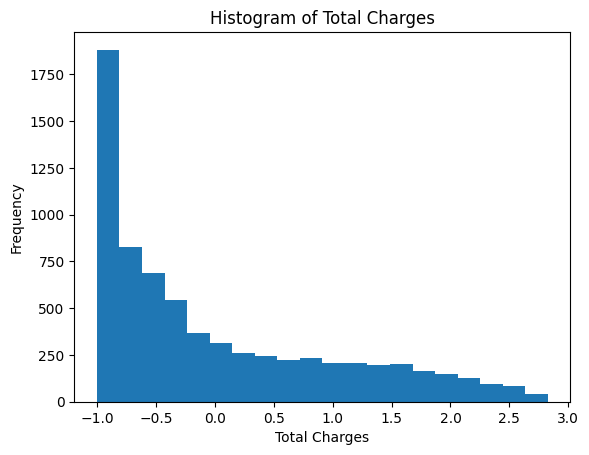

In [93]:
for feature in numerical_features:
    plt.hist(df[feature], bins=20)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {feature}')
    plt.show()

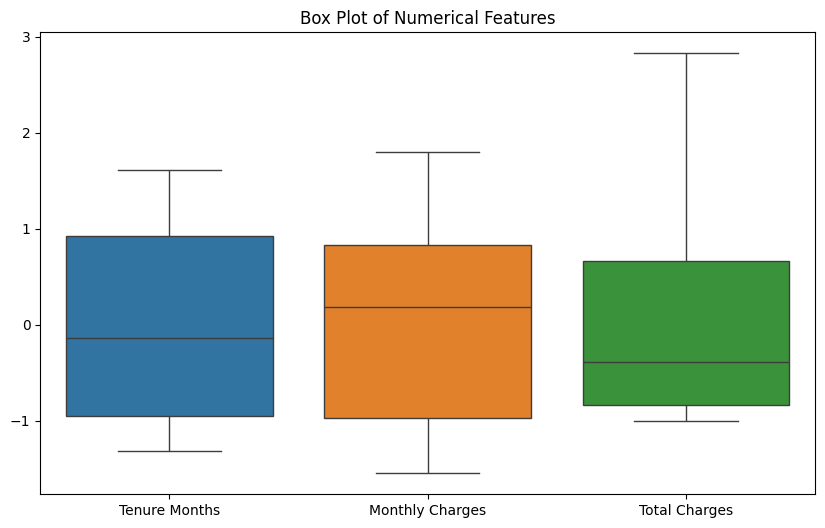

In [94]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[numerical_features])
plt.title('Box Plot of Numerical Features')
plt.show()

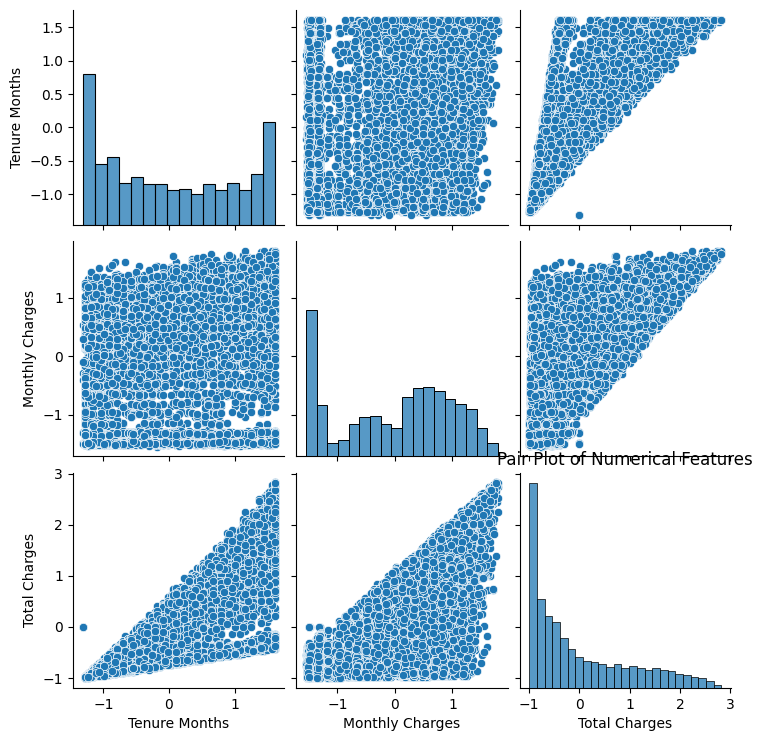

In [95]:
sns.pairplot(df[numerical_features])
plt.title('Pair Plot of Numerical Features')
plt.show()

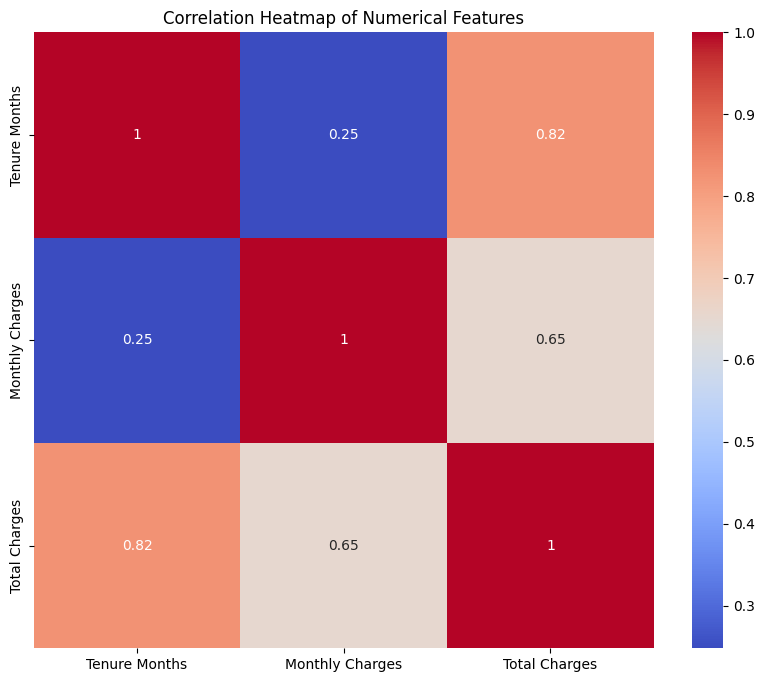

In [96]:
plt.figure(figsize=(10, 8))
correlation_matrix = df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

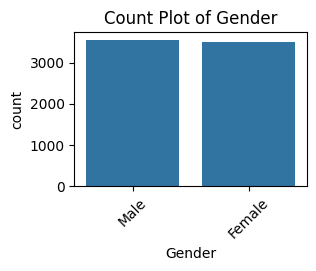

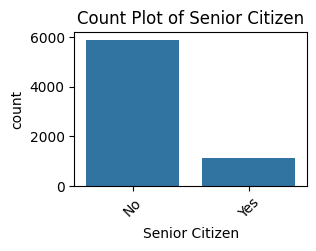

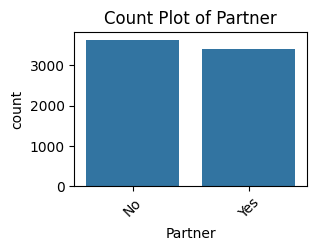

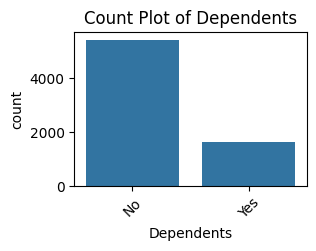

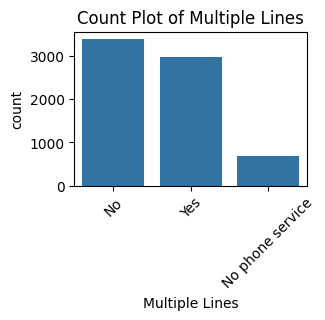

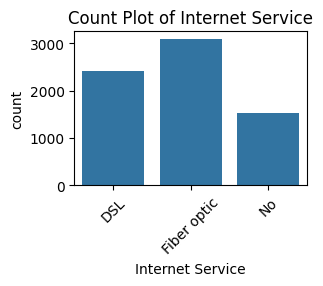

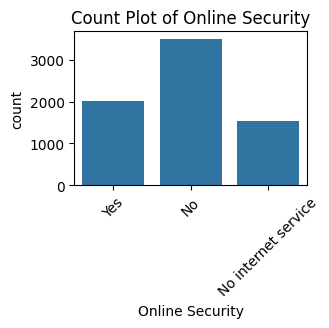

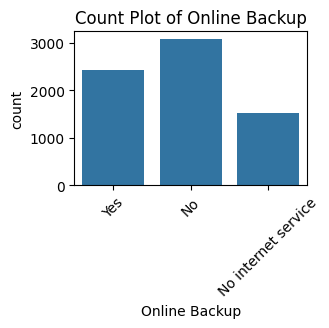

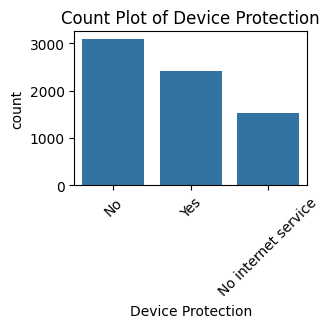

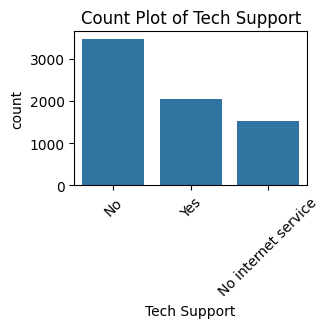

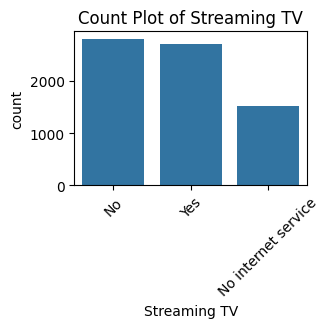

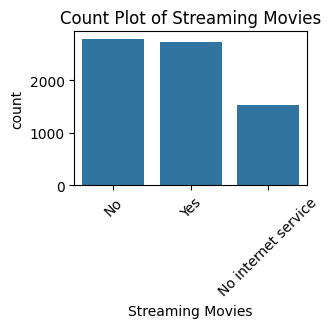

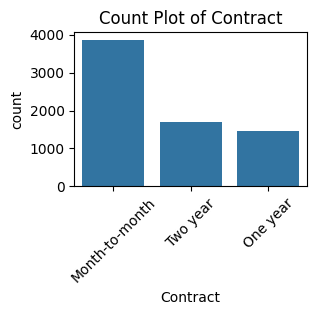

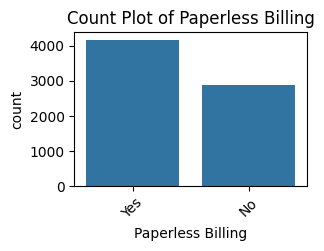

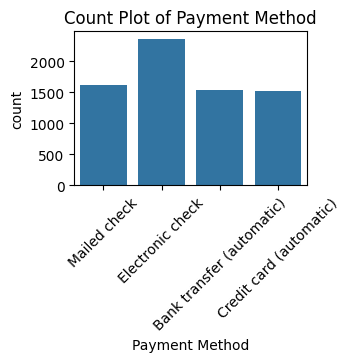

ValueError: Could not interpret value `Churn Reason` for `x`. An entry with this name does not appear in `data`.

<Figure size 300x200 with 0 Axes>

In [97]:
for feature in categorical_features:
    plt.figure(figsize=(3, 2))
    sns.countplot(x=feature, data=df)
    plt.title(f'Count Plot of {feature}')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
encoded_features = ['Gender_encoded', 'Senior Citizen_encoded', 'Partner_encoded', 'Dependents_encoded', 'Multiple Lines_encoded', 'Internet Service_encoded', 'Online Security_encoded', 'Online Backup_encoded', 'Device Protection_encoded', 'Tech Support_encoded', 'Streaming TV_encoded', 'Streaming Movies_encoded', 'Contract_encoded', 'Paperless Billing_encoded', 'Payment Method_encoded']  
for feature in encoded_features:
    print(f"Unique values in {feature}: {df[feature].unique()}")

# Check data types of encoded features
print("\nData types of encoded features:")
print(df[encoded_features].dtypes)

# Review summary statistics
print("\nSummary statistics of encoded features:")
print(df[encoded_features].describe())

# Count unique values in encoded features
print("\nCount of unique values in encoded features:")
print(df[encoded_features].nunique())

# MODELLING

In [ ]:
X = df.drop(columns=['Churn Value','Gender','Senior Citizen','Partner','Dependents', 'Multiple Lines','Internet Service','Online Security','Online Backup','Device Protection','Tech Support','Streaming TV','Streaming Movies','Contract','Paperless Billing','Payment Method'])  
y = df['Churn Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

In [ ]:
nan_count_of_X = X_train.isna().sum()
print(nan_count_of_X)

In [98]:
smote = SMOTE(random_state=42)
rus = RandomUnderSampler(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
X_train, y_train = rus.fit_resample(X_train, y_train)
print("Resampled training data shape:", X_train.shape)
print("Resampled training target shape:", y_train.shape)

Resampled training data shape: (8330, 18)
Resampled training target shape: (8330,)


In [101]:
train_accuracy = []
test_accuracy = []
precision = []
recall = []
f1 = []
cohen_kappa = []
roc = []
mathew = []
random_state = 2
classifiers = []
models = ["Naive Bayes","Logistic Regression","Decision Tree","RandomForest", "AdaBoost", "ExtraTrees","GradientBoosting","XGboost"]
classifiers.append(BernoulliNB())
classifiers.append(LogisticRegression())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier(random_state=random_state, max_depth = 10, max_features = 'sqrt', n_estimators=  300))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.5))
classifiers.append(ExtraTreesClassifier(random_state=random_state, criterion ='entropy', max_features = 'sqrt', min_samples_leaf = 20, min_samples_split = 15))
classifiers.append(GradientBoostingClassifier(random_state=random_state, learning_rate = 0.2, max_depth = 10, n_estimators = 200))
classifiers.append(XGBClassifier(random_state = random_state))
for clf, clf_name in zip(classifiers, models):
    print(f"Model: {clf_name}\n")
    clf.fit(X_train, y_train)
    train_preds = clf.predict(X_train)
    test_preds = clf.predict(X_test)
    train_accuracy.append(accuracy_score(y_train, train_preds))
    test_accuracy.append(accuracy_score(y_test, test_preds))
    precision.append(precision_score(y_test, test_preds))
    recall.append(recall_score(y_test, test_preds))
    f1.append(f1_score(y_test, test_preds))
    cohen_kappa.append(cohen_kappa_score(y_test, test_preds))
    roc.append(roc_auc_score(y_test, test_preds))
    mathew.append(matthews_corrcoef(y_test, test_preds))

    print('\n clasification report:\n', classification_report(y_test,test_preds))
    print('\n confussion matrix:\n',confusion_matrix(y_test, test_preds))
    print('\n')
    
scoreDF = pd.DataFrame({'Model' : models})
scoreDF['Train Accuracy'] = train_accuracy
scoreDF['Test Accuracy'] = test_accuracy
scoreDF['Precision'] =  precision
scoreDF['Recall'] =  recall
scoreDF['F1 Score'] = f1 
scoreDF['AUC Score'] = roc 
scoreDF['Matthew Correlation Coefficient'] = mathew
scoreDF['Cohen Kappa Score'] = cohen_kappa
scoreDF.set_index("Model")

Model: Naive Bayes


 clasification report:
               precision    recall  f1-score   support

           0       0.89      0.72      0.80      1009
           1       0.53      0.78      0.63       400

    accuracy                           0.74      1409
   macro avg       0.71      0.75      0.71      1409
weighted avg       0.79      0.74      0.75      1409


 confussion matrix:
 [[728 281]
 [ 89 311]]


Model: Logistic Regression


 clasification report:
               precision    recall  f1-score   support

           0       0.91      0.71      0.80      1009
           1       0.53      0.82      0.65       400

    accuracy                           0.74      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.80      0.74      0.75      1409


 confussion matrix:
 [[716 293]
 [ 70 330]]


Model: Decision Tree


 clasification report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81      100

D:\my_python_project\myenv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



 clasification report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81      1009
           1       0.53      0.60      0.56       400

    accuracy                           0.73      1409
   macro avg       0.68      0.69      0.68      1409
weighted avg       0.75      0.73      0.74      1409


 confussion matrix:
 [[795 214]
 [161 239]]


Model: ExtraTrees


 clasification report:
               precision    recall  f1-score   support

           0       0.90      0.75      0.82      1009
           1       0.56      0.80      0.66       400

    accuracy                           0.77      1409
   macro avg       0.73      0.78      0.74      1409
weighted avg       0.81      0.77      0.77      1409


 confussion matrix:
 [[758 251]
 [ 80 320]]


Model: GradientBoosting


 clasification report:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      1009
           1       0.62 

,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,AUC Score,Matthew Correlation Coefficient,Cohen Kappa Score
Model,,,,,,,,
Naive Bayes,0.763745,0.737402,0.525338,0.7775,0.627016,0.749503,0.455837,0.435868
Logistic Regression,0.794118,0.742370,0.529695,0.8250,0.645161,0.767307,0.485356,0.457621
Decision Tree,0.998439,0.734564,0.528634,0.6000,0.562061,0.693954,0.374262,0.372724
RandomForest,0.894958,0.775727,0.578358,0.7750,0.662393,0.775508,0.511741,0.499739
AdaBoost,0.998439,0.733854,0.527594,0.5975,0.560375,0.692704,0.372065,0.370590
ExtraTrees,0.825090,0.765082,0.560420,0.8000,0.659114,0.775619,0.506262,0.488249
GradientBoosting,0.998439,0.786373,0.617021,0.6525,0.634265,0.745972,0.483931,0.483554
XGboost,0.939136,0.772889,0.579681,0.7275,0.645233,0.759191,0.488056,0.481341
